In [75]:
#automatically reload stuff
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import Utils
from Constants import Const
from Stats import *
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

In [2]:
data = pd.read_pickle('randomized_data.csv')
for col in data.columns:
    if isinstance(data[col].values[0],str):
        data[col] = data[col].apply(Utils.process_arrays).values
data

,id,D10,D15,D2,D20,D25,D30,D35,D40,D45,...,symptoms_skin,symptoms_sleep,symptoms_sob,symptoms_swallow,symptoms_taste,symptoms_teeth,symptoms_voice,symptoms_vomit,symptoms_walking,symptoms_work
0,114,"[54.75760124683741, 29.87509198552768, 54.0083...","[28.816216758705874, 31.517140274838425, 48.78...","[28.501283396164652, 34.84990908225134, 58.440...","[38.2527424640652, 31.847256024695657, 48.0339...","[43.5336981596681, 33.94193692222466, 57.35094...","[41.291048237721434, 41.28748905316591, 41.281...","[39.1622205973233, 29.581702185431368, 39.1655...","[15.88855398749214, 28.829775719156192, 42.441...","[21.271459499433064, 27.989380791905752, 37.25...",...,"[0.008370289375590213, 0.005889263508835647, 0...","[0.0033309644042845534, 4.006298466311918, 8.0...","[0.0019607464880551572, 0.009061098792857238, ...","[0.0010218681312014143, 0.00851252528495658, 0...","[0.004837942965142348, 2.008234017238401, 1.00...","[0.009686620174363425, 0.008836809885588942, 8...","[2.001202670107838, 1.0080816601843812, 0.0057...","[0.0010753790891942683, 0.0057516692718538025,...","[0.009284232683901482, 1.0008863275145552, 0.0...","[0.0008003370149928057, 0.0028681656834228485,..."
1,79,"[21.601750652965976, 32.66456512376025, 62.161...","[36.285721322078224, 31.303284730486567, 62.37...","[0.02859659504535902, 5.591988357504097, 7.307...","[15.607532482210964, 20.315855048341678, 53.06...","[21.100184085286863, 30.50821804807081, 47.944...","[13.686542659033021, 23.319286013234127, 49.22...","[8.298963161614662, 9.75108923329538, 24.77520...","[10.528002887113258, 10.443649011079948, 19.08...","[15.360664255208023, 19.350579851047918, 49.90...",...,"[0.0017778827449386326, 0.0027045971312439953,...","[1.0070701997194145, 1.0079618992384318, 2.003...","[0.004983366011429358, 0.0019375119468448099, ...","[0.002113244666293296, 0.002223629935724603, 0...","[0.002230322870446554, 0.0038844472920445995, ...","[1.002386815219118, 0.009722865261977316, 0.00...","[4.004337639909264, 0.005480296511527999, 0.00...","[0.0020850373719093827, 0.009487218848486122, ...","[0.006501976546685309, 0.0016583204868106949, ...","[3.170711732508602e-05, 0.007355934283068342, ..."
2,531,"[29.649075859893006, 29.849172972785556, 71.69...","[48.600597900118565, 27.94502399311137, 13.635...","[39.97623445356506, 34.72507222697527, 60.9134...","[41.87975685495099, 35.657554430536614, 55.289...","[43.539346215224086, 26.20599804279998, 43.540...","[17.664584724372407, 28.76869334830777, 49.814...","[39.164577151505355, 39.157410806511805, 39.15...","[30.04753502741789, 20.033671905118016, 55.349...","[10.713162673937724, 17.720174974251744, 42.06...",...,"[0.0029528830497805446, 1.0037166256428727, 0....","[2.006468177784938, 7.008329576189921, 4.00556...","[0.0060693254675372385, 0.002161843484128293, ...","[2.0005000090207394, 1.0049026681744182, 0.001...","[0.005869138868511073, 1.0002513432333937, 1.0...","[1.0087924686843166, 0.0006681568436458607, 0....","[0.003096981920649492, 0.0015596648279911497, ...","[0.0022465411621825373, 0.008859362830683462, ...","[0.005255112106759289, 0.007372854902964592, 1...","[10.004508961731098, 10.002465084737015, 3.008..."
3,615,"[25.82155537760335, 26.408307848158863, 59.969...","[48.59730228968422, 16.484603326503773, 58.194...","[21.086359524720237, 26.0950326399358, 55.4074...","[30.863871943781163, 25.03701671620436, 61.846...","[18.675343964860502, 27.022377607751633, 54.44...","[23.789474108173476, 31.024540367100194, 47.79...","[3.162999242148344, 25.84948113353558, 24.2346...","[42.064484024965, 31.567824895162687, 50.41402...","[35.13386568414568, 35.132675096383736, 35.134...",...,"[0.0007490286145783709, 0.008025795858269066, ...","[0.006793648621153674, 0.004449634931569275, 0...","[0.009408103555460793, 0.001554233909949031, 0...","[6.002522615819314, 7.008890249819656, 6.00810...","[0.004277904651299169, 0.008688712015069646, 0...","[0.0018133182925046132, 0.0008290132601344691,...","[2.002930348214584, 0.0

In [26]:
def add_dose_limits(df,organ_list=None):
    #dose limits as binary values from https://applications.emro.who.int/imemrf/Rep_Radiother_Oncol/Rep_Radiother_Oncol_2013_1_1_35_48.pdf
    #not inlcudeing other stuff like eyes at this time
    #also, my max dose is weird so I'm using V10 for that because I feel like that makes sense
    if organ_list is None:
        organ_list = Const.organ_list[:]
    df = df.copy()
    original_cols = set(df.columns)
    getval = lambda organ,param: df[param].apply(lambda x: x[organ_list.index(organ)])
    get_lr_val = lambda organ,param: np.maximum(getval('Lt_'+organ,param),getval('Rt_'+organ,param))
    
    maxdose_var = 'max_dose'
    #symptomatic necrosis
    df['Brainstem_limit'] = (getval('Brainstem','D2') > 59) | (getval('Brainstem','D99') > 54)
    
    #myelopathy
    df['Spinal_Cord_limit'] = getval('Spinal_Cord',maxdose_var) > 50
    
    #xerostomia. >25 for 1 or >20 for both
    df['Parotid_Gland_limit'] = (get_lr_val('Parotid_Gland','mean_dose') > 20) | (getval('Lt_Parotid_Gland','mean_dose') > 25) | (getval('Rt_Parotid_Gland','mean_dose') > 25)
    
    #alternative threshold
    df['Parotid_Gland_limit2'] = get_lr_val('Parotid_Gland','mean_dose') >= 35.7
    
    #there is 50 for PEG tube and 60 for aspiration so i'll do 50
    for o in ['IPC','MPC',"SPC"]:
        df[o+"_limit"] = getval(o,'mean_dose') > 50
        df[o+"_limit2"] = getval(o,'mean_dose') > 60
    
    #ORN?
    df['Mandible_limit'] = getval('Mandible',maxdose_var) > 70
    
    #edema
    df['Larynx_limit'] = getval('Larynx','V50') > 27
    
    #Nerve damage
    df['Brachial_Plexus_limit'] = get_lr_val('Brachial_Plexus',maxdose_var) > 60
    
    #Esophagitus
    elimits = [('V35',50),('V50',40),('V70',20),('V60',30)]
    df['Esophagus_limit'] = np.stack([(getval('Esophagus',v) > lim) for v,lim in elimits]).sum(axis=0) > 0
    
    return df

#add in pre-defined dose  thresholds for later
data = add_dose_limits(data)
data[[c for c in data.columns if '_limit' in c]].describe()

,Brainstem_limit,Spinal_Cord_limit,Parotid_Gland_limit,Parotid_Gland_limit2,IPC_limit,IPC_limit2,MPC_limit,MPC_limit2,SPC_limit,SPC_limit2,Mandible_limit,Larynx_limit,Brachial_Plexus_limit,Esophagus_limit
count,349,349,349,349,349,349,349,349,349,349,349,349,349,349
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,False,False,True,False,False,False,True,False,True,True,True,False,True,False
freq,348,335,306,260,282,324,214,229,267,179,207,276,228,315


In [53]:
#load all our data with pre-defined parameters

#organs used in the clustering
ooi = [
    'Rt_Parotid_Gland',
    'Lt_Parotid_Gland',
    'Rt_Submandibular_Gland',
    'Lt_Submandibular_Gland',
    'Hard_Palate',
      ]
#number of clusters
n =3

#dvh features to use in the clustering
cluster_features = ['V25','V30','V35','V40','V45','V50','V55',"V60"]

ct = ClusterTester(data,
                   ooi,
                   n_clusters=n,
                   outcome_dates=[33],
                   cluster_features=cluster_features,
                  )

In [54]:
print(ct.show_all_rules())

V40_Lt_Submandibular_Gland>83.00000396166806, V25_Rt_Parotid_Gland>10.000003961668057 
 roc_cluster:0.67 roc_outcome_3:0.478 roc_outcome_change_3:0.482 cluster_precision:[0.7   0.662] cluster_recall:[0.552 0.788] cluster_f1:[0.617 0.72 ] roc_outcome_5:0.477 roc_outcome_change_5:0.459 roc_outcome_7:0.489 roc_outcome_change_7:0.5 
 _________________ 
 V35_Rt_Submandibular_Gland>73.00000396166806, V45_Hard_Palate>7.000003961668057 
 roc_cluster:0.385 roc_outcome_3:0.503 roc_outcome_change_3:0.48 cluster_precision:[0.405 0.151] cluster_recall:[0.727 0.043] cluster_f1:[0.521 0.068] roc_outcome_5:0.464 roc_outcome_change_5:0.475 roc_outcome_7:0.465 roc_outcome_change_7:0.4 
 _________________ 
 V45_Hard_Palate>7.000003961668057, V35_Rt_Parotid_Gland>2.0000039616680567, V35_Rt_Submandibular_Gland>73.00000396166806 
 roc_cluster:0.385 roc_outcome_3:0.503 roc_outcome_change_3:0.48 cluster_precision:[0.405 0.151] cluster_recall:[0.727 0.043] cluster_f1:[0.521 0.068] roc_outcome_5:0.464 roc_outco

In [56]:
def show_dems(ct):
    #demographics broken down by original cluster
    test = ct.get_demographic_breakdown()
    
    #demographics broken down by the simplified cluster
    mtest = ct.get_demographic_breakdown(use_mimic=True)

    for k,v in test.items():
        print(k)
        print(v)
        print('--mimic--')
        print(mtest[k].iloc[1])
        print('_________________')
        print('_________________')
     
#demographic breakdown by cluster and by simplified cluster
show_dems(ct)

counts
0     35
1    130
2    184
Name: cluster, dtype: int64
--mimic--
219
_________________
_________________
is_male
             pval      tval overall_pval       False         True
cluster                                                          
0        0.556999  0.344926     0.564297   5 (14.3)%   30 (85.7)%
1        0.864565  0.029093     0.564297  14 (10.8)%  116 (89.2)%
2        0.485807    0.4858     0.564297   16 (8.7)%  168 (91.3)%
--mimic--
pval               0.201835
tval               1.629047
overall_pval       0.201835
False             18 (8.2)%
True            201 (91.8)%
Name: 1, dtype: object
_________________
_________________
t_stage
             pval      tval overall_pval          t0          t1          t2  \
cluster                                                                        
0        0.524324  5.153164     0.644913    1 (2.9)%   9 (25.7)%  13 (37.1)%   
1         0.54001  5.029693     0.644913  13 (10.0)%  38 (29.2)%  46 (35.4)%   
2        0.68

cluster 1 symptom at [0] [0.5194808865664222, 0.8909722768902341, 1.348169503298472]
cluster 2 symptom at [0] [0.8206354598606892, 1.089570477750236, 1.3513061290020363]
cluster 3 symptom at [0] [0.6845026086111454, 0.9183564090943679, 1.152035021094233]
cluster 3 (simplified) symptom at [0] [0.772423024435826, 0.9550979444285473, 1.1652462500200964]
cluster 1 symptom at [13] [3.1181492333261525, 3.8046159394688006, 4.376069477649657]
cluster 2 symptom at [13] [3.3976314747744727, 3.7511846759281737, 4.097308950545933]
cluster 3 symptom at [13] [3.548438105247154, 3.890903052259672, 4.211370953476558]
cluster 3 (simplified) symptom at [13] [3.5209737444696203, 3.8131712859837377, 4.119407447352392]
cluster 1 symptom at [33] [3.033377937648717, 3.775848769897053, 4.490096454739822]
cluster 2 symptom at [33] [4.313155543851345, 4.621023405772144, 5.075259724358464]
cluster 3 symptom at [33] [3.955742179899311, 4.255096624271048, 4.614007874913094]
cluster 3 (simplified) symptom at [33] [

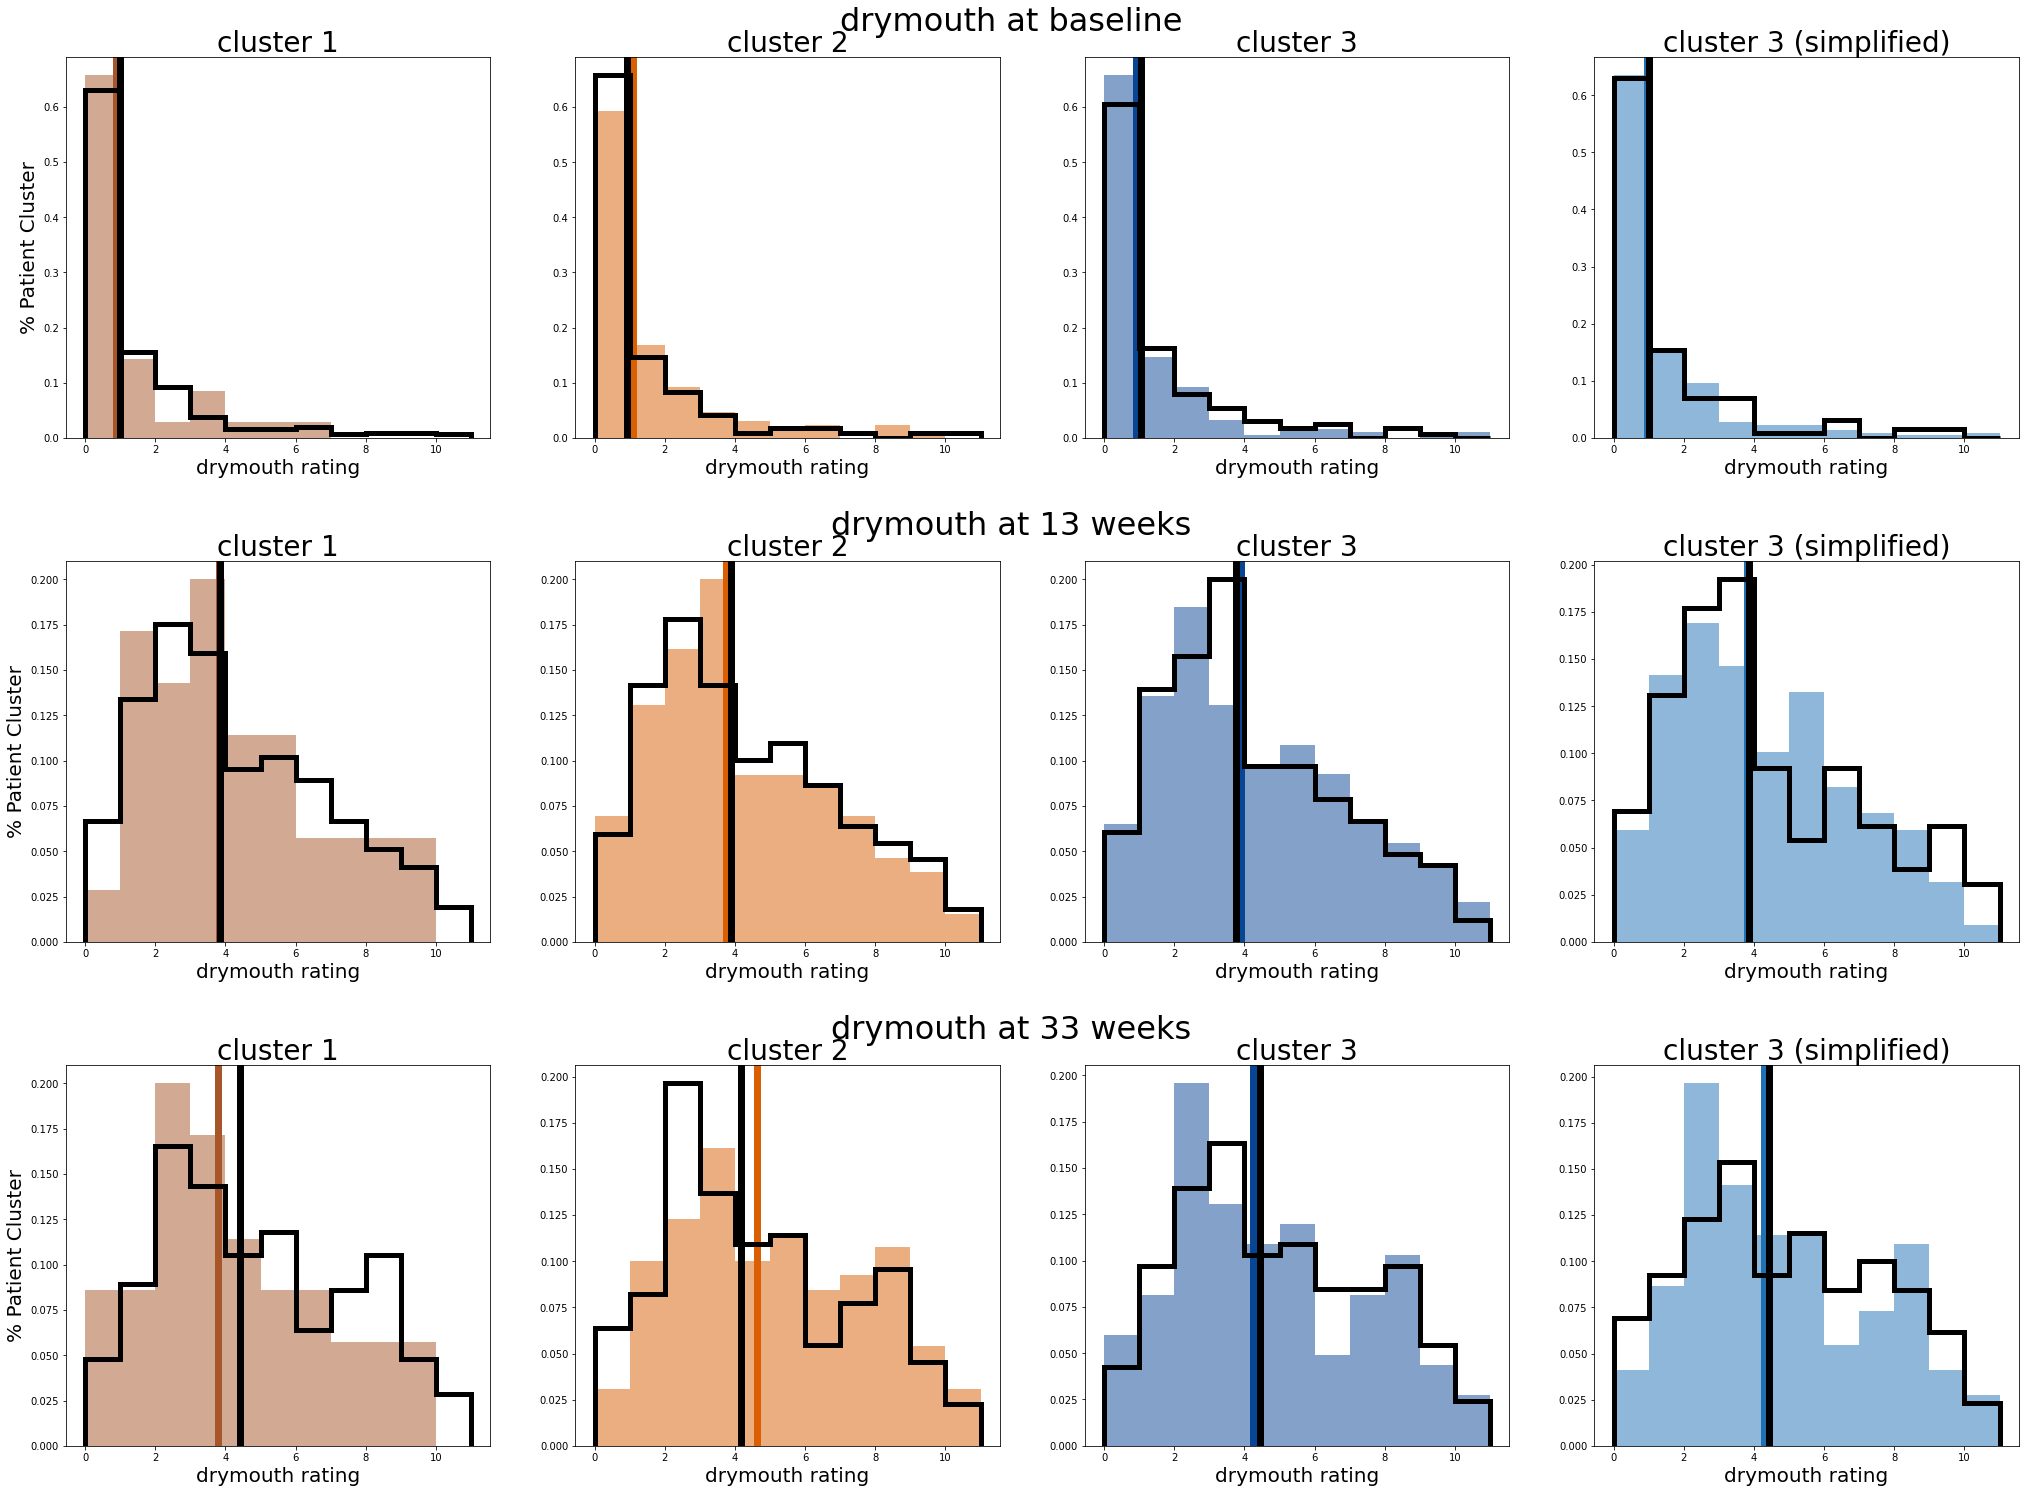

In [62]:
def bootstrap_conf_interval(vals, n = 200):
    results = []
    for i in range(n):
        tempvals = np.random.choice(vals,size=len(vals),replace=True)
        results.append(tempvals.mean())
    results = sorted(results)
    minval = results[int(len(results)*.05)]
    maxval =results[int(len(results)*.95)]
    return [minval, vals.mean(), maxval] 

def symptom_histogram(ct,symptom=None,datelist=[[0],[13],[33]],size=7,**kwargs):
    df = ct.get_cluster_df(**kwargs).copy()
    mimic_df = ct.get_cluster_df(use_mimic=True)
    
    cnames = []
    
    for cluster in sorted(df.dose_clusters.unique()):

        name = 'cluster ' + str(cluster+1)
        df[name] = df['dose_clusters'] == cluster
        cnames.append(name)
    cnames.append('cluster 3 (simplified)')
    df[cnames[-1]] = mimic_df.dose_clusters
    (figwidth,figheight) = ((ct.n_clusters+2)*size,len(datelist)*size)
    fig = plt.figure(figsize=(figwidth,figheight))
    subfigs = fig.subfigures(len(datelist),1,wspace=1)
    df_dates =df.dates.iloc[0]
    
    if symptom is None:
        symptom = ct.symptoms[0]
        
    for row, dates in enumerate(datelist):
        subfig = subfigs[row]
        weekstring = '-'.join([str(d) for d in dates]) if len(dates) > 1 else str(dates[0])  
        if weekstring == '0':
            weekstring = 'baseline'
        else:
            weekstring += ' weeks'
        subfig.suptitle(symptom + ' at ' + weekstring ,fontsize=32)
        axes = subfig.subplots(1,len(cnames))
        dlocs = [df_dates.index(d) for d in dates if d in df_dates]
        df['s'] = df['symptoms_'+symptom].apply(lambda x: np.max([x[d] for d in dlocs]))
        colors = ['#a65628','#d95f02','#084594','#2171b5','#9ecae1']

        for col, name in enumerate(cnames):
            axis = axes[col]
            for thing in [True,False]:
                color = colors[col]
                if thing is False:
                    color = 'black'
                subdf = df[df[name].astype(bool) == thing]
                hvals = subdf.s.values
                htype = 'stepfilled' if thing else 'step'
                alpha = 1 if (htype == 'step') else .5
                axis.hist(hvals,bins=[i for i in range(12)],color=color,alpha=alpha,linewidth=5,histtype=htype,density=True)
                if thing:
                    print(name, 'symptom at', dates, bootstrap_conf_interval(hvals))
                axis.axvline(hvals.mean(),color=color,linewidth=7) 
            axis.set_title(name,fontsize=28)
            axis.set_xlabel(symptom + ' rating',fontsize=20)
            if col <= 0:
                axis.set_ylabel('% Patient Cluster',fontsize=20)
    return 

#plot histogram of target symptom (drymouth) broken down by cluster
symptom_histogram(ct)

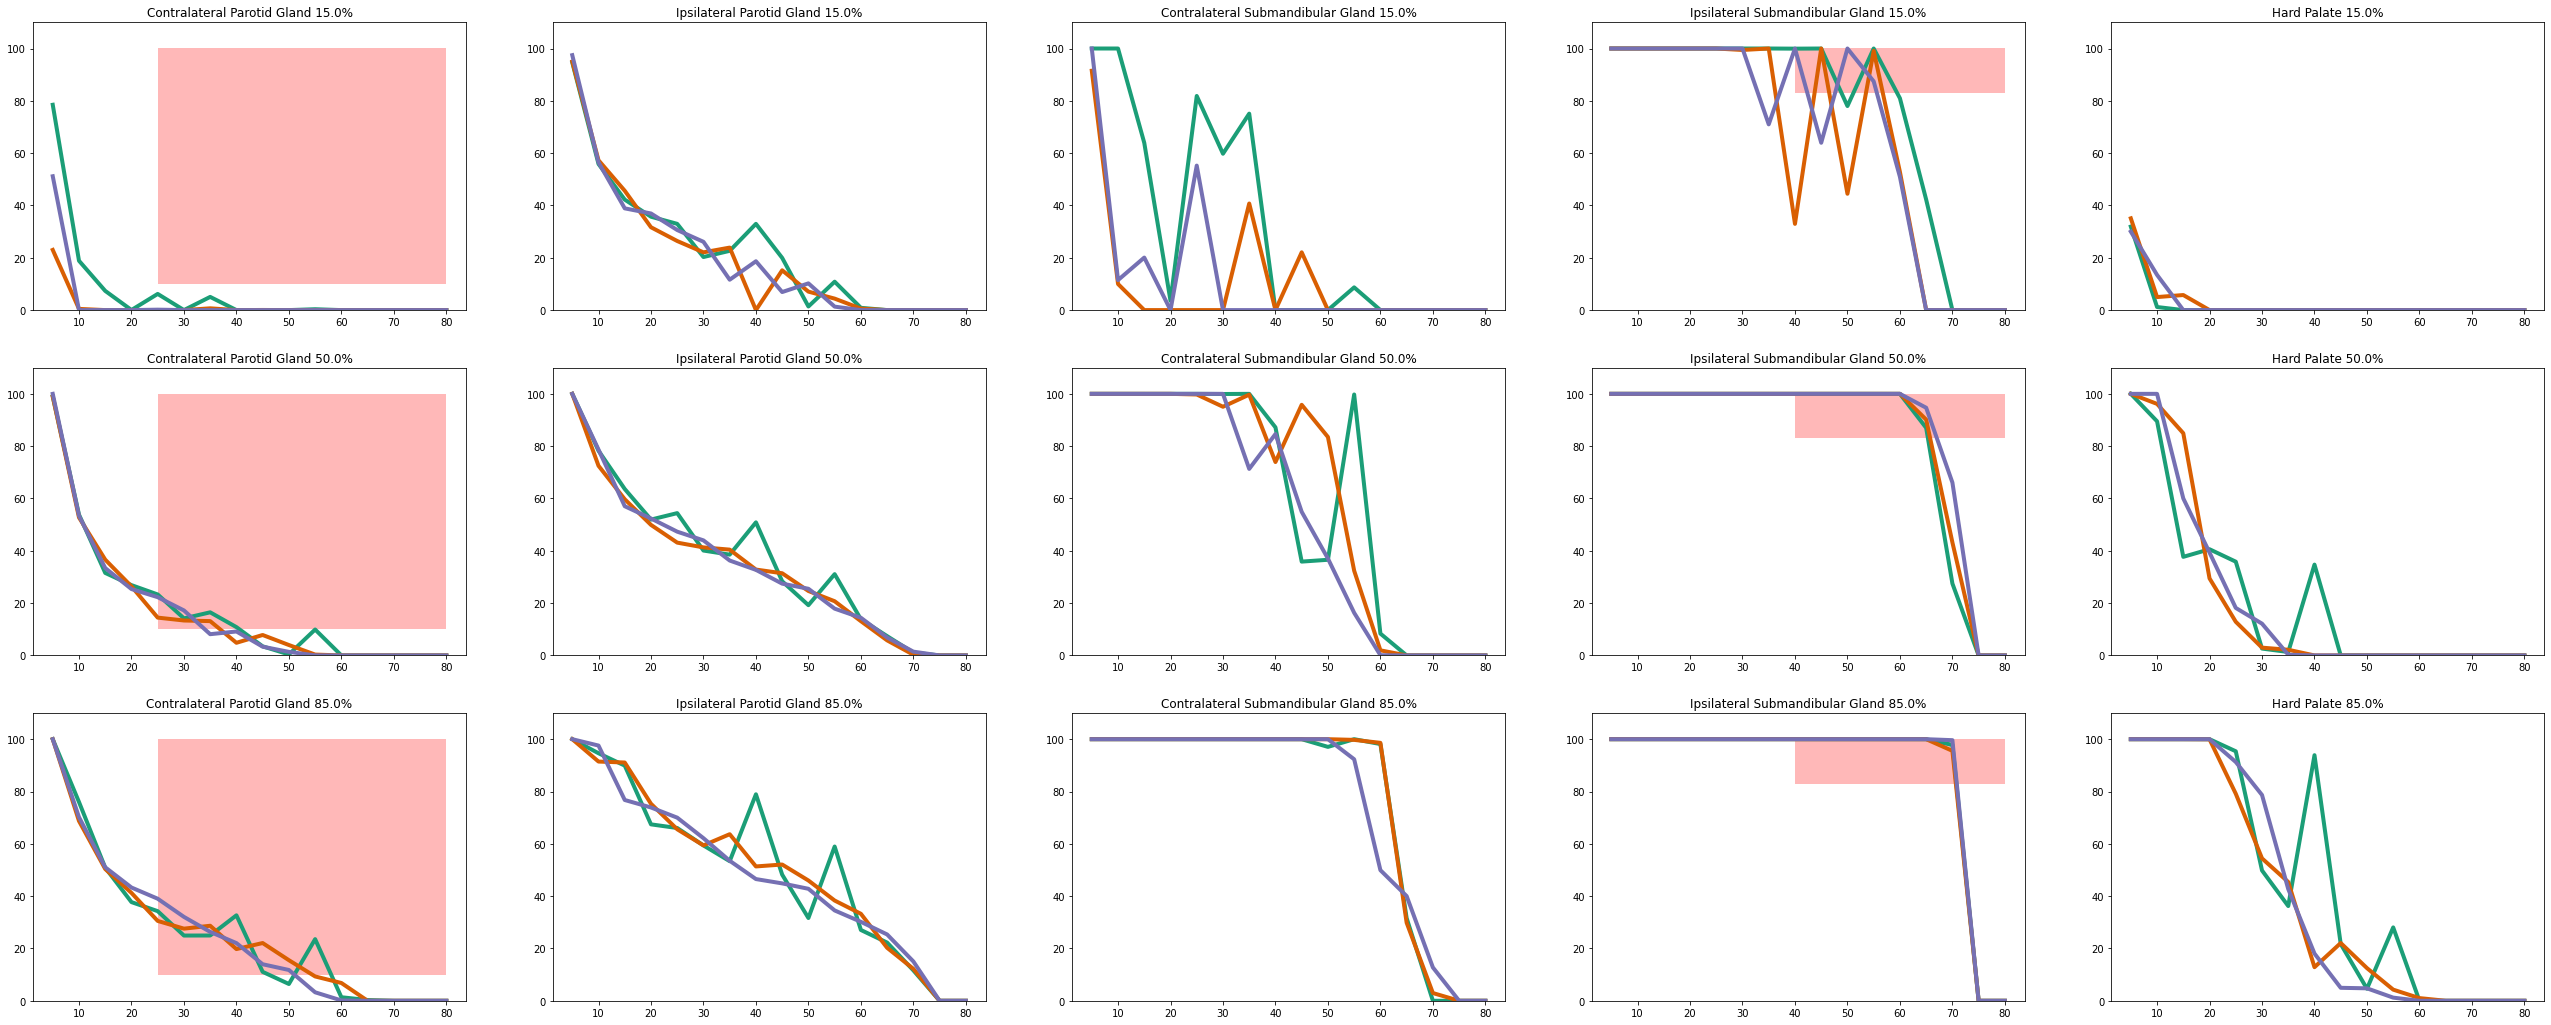

In [68]:
def get_cluster_dvhs(ctester,features=None,organs=None,**kwargs):
    if features is None:
        features= ctester.cluster_features[:]
    if organs is None:
        organs = ctester.cluster_organs[:]
        
    df = ctester.get_cluster_df(**kwargs)
    opositions = [Const.organ_list.index(i) for i in organs if i in Const.organ_list]
    filter_organs = lambda x: np.array([x[o] for o in opositions])
    cluster_vals = {}
    for cluster, subdf in df.groupby('dose_clusters'):
        vals = []
        for feature in features:
            farray = np.stack(subdf[feature].apply(filter_organs).values)
            vals.append(farray.T)
        vals = np.stack(vals,axis=-1) #organs x patients x features
        vals = np.swapaxes(vals,1,-1) #organs x features x patients
        cluster_vals[cluster] = vals
    return cluster_vals

def get_rule_points(ct):
    rule = list(ct.current_rules.values())[0][0]
    features = rule['features']
    thresholds = rule['thresholds']
    get_val = lambda x: re.match('V(\d+)_([a-zA-Z_]+)',x).groups()
    fzip = [get_val(f) for f in features]
    odict = {}
    for i,(num, organ) in enumerate(fzip):
        num = int(num)
        thold = thresholds[i]
        odict[organ] = {'value': num,'threshold': thold}
    return odict

def plot_cluster_dvhs(ctester,quantiles=[.15,.5,.85],features=None,organs=None,include_mimic=False,size=6,**kwargs):
    if features is None:
        features= get_all_dvh(ct)#ctester.cluster_features[:]
    if organs is None:
        organs = ctester.cluster_organs[:]
    data = get_cluster_dvhs(ctester,features=features,organs=organs,**kwargs)
    if include_mimic and not kwargs.get('use_mimic',False):
        data2 = get_cluster_dvhs(ctester,features=features,organs=organs,use_mimic=True,**kwargs)
        data[ctester.n_clusters] = data2[1]
    (n_rows, n_cols) = (len(quantiles),len(organs))
    fig,axes = plt.subplots(n_rows,n_cols,figsize=(1.5*size*n_cols,size*n_rows))
    xlabels = [int(f[1:]) for f in features]
    ylim = np.max([v.max() for k,v in data.items()])
    colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','grey','navy','#e6ab02']
    rules = get_rule_points(ctester)
    format_title = lambda x: x.replace('Lt','Ipsilateral').replace('Rt','Contralateral').replace('_',' ')
    for clustkey, carray in data.items():
        for col, organ in enumerate(organs):
            rule = rules.get(organ)
            qtiles = np.nanquantile(carray[col],quantiles,axis=-1)
            for row,quant in enumerate(qtiles):
                axis = axes[row,col]
                axis.plot(xlabels,quant,linewidth=4,color=colors[clustkey])
                axis.set_ylim((0,ylim*1.1))
                axis.set_title(format_title(organ) + ' ' + str(100*quantiles[row]) + '%')
                if rule is not None:
                    corner = [rule['value'],rule['threshold']]
                    rheight = ylim - corner[1]
                    rwidth = xlabels[-1] - corner[0]
                    rect = Rectangle(corner,rwidth,rheight,alpha=.1,facecolor='red')
                    axis.add_patch(rect)
    return

plot_cluster_dvhs(ct)

['Rt_Parotid_Gland', 'Lt_Parotid_Gland', 'Rt_Submandibular_Gland', 'Lt_Submandibular_Gland', 'Hard_Palate']


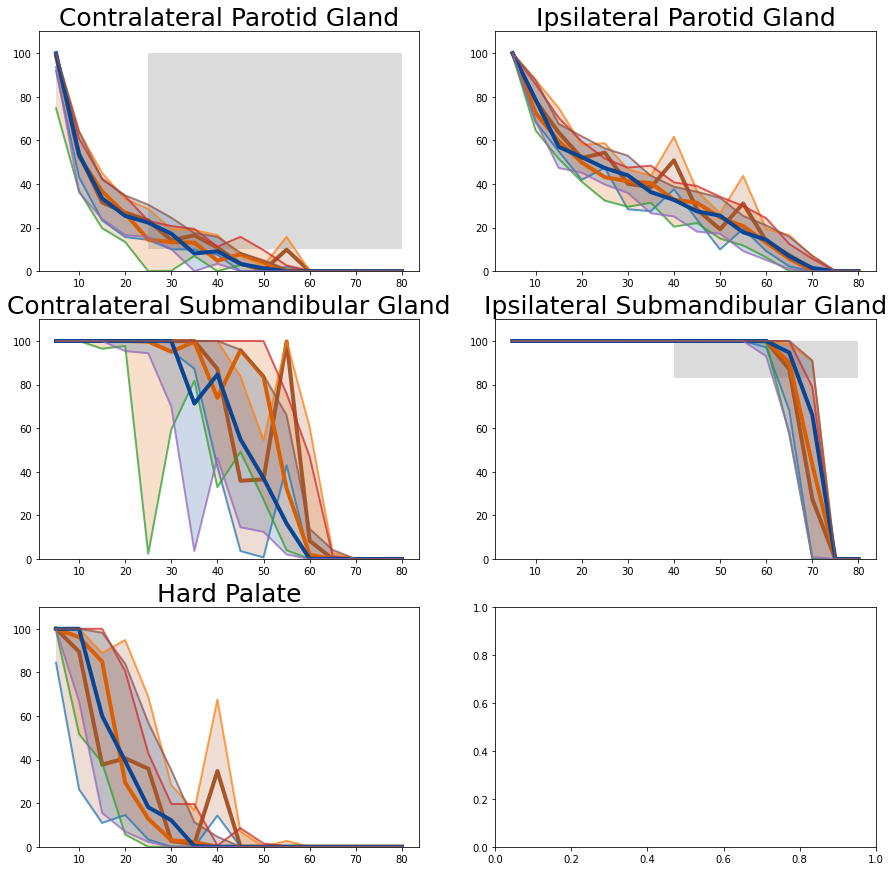

In [67]:
def plot_cluster_dvhs_alt(ctester,quantile_levels=[[.3,.70]],features=None,organs=None,include_mimic=False,size=5,**kwargs):
    #variant where it's all one column
    #assume quantiles is 3 values (lower bound, mean, upper bound)
    if features is None:
        features= get_all_dvh(ct)#ctester.cluster_features[:]
    if organs is None:
        organs = ctester.cluster_organs[:]
    print(organs)
    data = get_cluster_dvhs(ctester,features=features,organs=organs,**kwargs)
    if include_mimic and not kwargs.get('use_mimic',False):
        data2 = get_cluster_dvhs(ctester,features=features,organs=organs,use_mimic=True,**kwargs)
        data[ctester.n_clusters] = data2[1]
    n_rows = (len(organs)//2) + 1
    fig,axes = plt.subplots(n_rows,2,figsize=(3*size,size*n_rows))
    xlabels = [int(f[1:]) for f in features]
    ylim = np.max([v.max() for k,v in data.items()])
    colors = ['#a65628','#d95f02','#084594','#2171b5','#9ecae1']
    rules = get_rule_points(ctester)
    format_title = lambda x: x.replace('Lt','Ipsilateral').replace('Rt','Contralateral').replace('_',' ')
    
    for clustkey, carray in data.items():
        color = colors[clustkey]
        row = 0
        col = 0
        for pos, organ in enumerate(organs):
            axis=axes[row,col]
            col += 1
            if col > 1:
                col = 0
                row += 1
            rule = rules.get(organ)
            avg = np.nanmedian(carray[pos],axis=-1)
            axis.plot(xlabels,avg,linewidth=4,color=color)
            for quantiles in quantile_levels:
                qtiles = np.nanquantile(carray[pos],quantiles,axis=-1)
                axis.fill_between(xlabels,qtiles[0],qtiles[-1],facecolor=color,alpha=.2)
                for q in qtiles:
                    axis.plot(xlabels,q,linewidth=2,alpha=.75)
                
            axis.set_ylim((0,ylim*1.1))
            axis.set_title(format_title(organ),fontsize=25)
            if rule is not None:
                corner = [rule['value'],rule['threshold']]
                rheight = ylim - corner[1]
                rwidth = xlabels[-1] - corner[0]
                rect = Rectangle(corner,rwidth,rheight,alpha=.1,facecolor='grey')
                axis.add_patch(rect)
                
    return

#plot dvh values of each cluster with 30-70% confidence intervals
#also shows each rule as a rectangle
#synthetic data so the clusters may have low variance
plot_cluster_dvhs_alt(ct)

In [34]:
def lrt_scores(ct,confounders=None,**kwargs):
    #returns a nice formatted table of performance for non-crossvalidated regression based tests (lrt, aic, bic) + delong pval on cross-validated stuff
    # -1 in cluster means all clusters
    # linear: -1 -> linear predictor of change from baselines, 0 -> linear predictor of raw value. Negative values are change from baseline >= value, while normal values are raw value >= threshold
    if confounders is None:
        #the class has a set of default confoudners
        confounders = [ct.default_confounders[:]]
    clusters = [None] + [n for n in range(ct.n_clusters)]
    
    #get lrt test scores for clusters and outcomes 
    lrt_df = ct.get_lrt_correlation_df(use_mimic=False,clusters=clusters,confounder_list=confounders,include_delong=False,**kwargs)
    
    #get lrt scores with simplified lcusters and outcomes
    mimic = ct.get_lrt_correlation_df(use_mimic=True,confounder_list=confounders,include_delong=False,**kwargs)
    mimic['cluster'] = 'simplified'
    
    #merge results
    shared_cols = [c for c in lrt_df.columns if c in mimic.columns]
    lrt_df = pd.concat([lrt_df,mimic],axis=0)
#     to_sort = ['threshold','confounders']
    fix = lambda d: d['confounders'].apply(lambda x: ','.join(x))
    
    lrt_df['confounders'] = fix(lrt_df)
    #sorting results to make it easier to read
    lrt_df = lrt_df.sort_values('confounders',kind='mergesort')
    tlist = [0,1,2,3,4,5,6,7,-1,-2,-3,-4,-5,-6,-7]
    tlist = [t for t in tlist if t in lrt_df.threshold.unique()]
    lrt_df = lrt_df.set_index('threshold').loc[tlist,:].reset_index()
    lrt_df = lrt_df[shared_cols]

    drop_dup_cols = lambda d: d.loc[:,~d.columns.duplicated()]
    lrt_df = drop_dup_cols(lrt_df).groupby(['threshold','cluster','confounders']).first()
    return lrt_df

#confounders to use for likelihood ratio multivariate tests
#all values are binary
confounders = [
    't_severe', #t-stage >= 3
    'n_severe', #n-stage >= 2c
     'performance_1', 'performance_2', #ecog performance scores of 1 or 2
    'hpv', #hpv/16 positive 
    'age_65', #age >= 65 years old
    'BOT','Tonsil', #primary tumor subsite at base-of-tongue or tonsil (most popular sites)
    'Parotid_Gland_limit', #
            ]
lrt_scores(ct)

outcome_change  \
threshold cluster    confounders                                                          
-7        -1         t_severe,n_severe,performance_1,performance_2,h...            True   
          0          t_severe,n_severe,performance_1,performance_2,h...            True   
          1          t_severe,n_severe,performance_1,performance_2,h...            True   
          2          t_severe,n_severe,performance_1,performance_2,h...            True   
          simplified t_severe,n_severe,performance_1,performance_2,h...            True   
-5        -1         t_severe,n_severe,performance_1,performance_2,h...            True   
          0          t_severe,n_severe,performance_1,performance_2,h...            True   
          1          t_severe,n_severe,performance_1,performance_2,h...            True   
          2          t_severe,n_severe,performance_1,performance_2,h...            True   
          simplified t_severe,n_severe,performance_1,performance_2,h...            True   
-3        -1         t_severe,n_severe,performance_1,performance_2,h...            True   
          0          t_severe,n_severe,performance_1,performance_2,h...            True   
          1          t_severe,n_severe,performance_1,performance_2,h...            True   
          2          t_severe,n_severe,performance_1,performance_2,h...            True   
          simplified t_severe,n_severe,performance_1,performance_2,h...            True   
-1        -1         t_severe,n_severe,performance_1,performance_2,h...            True   
          0          t_severe,n_severe,performance_1,performance_2,h...            True   
          1          t_severe,n_severe,performance_1,performance_2,h...            True   
          2          t_severe,n_severe,performance_1,performance_2,h...            True   
          simplified t_severe,n_severe,performance_1,performance_2,h...            True   
 0        -1         t_severe,n_severe,performance_1,performance_2,h...           False   
          0          t_severe,n_severe,performance_1,performance_2,h...           False   
          1          t_severe,n_severe,performance_1,performance_2,h...           False   
          2          t_severe,n_severe,performance_1,performance_2,h...           False   
          simplified t_severe,n_severe,performance_1,performance_2,h...           False   
 3        -1         t_severe,n_severe,performance_1,performance_2,h...           False   
          0          t_severe,n_severe,performance_1,performance_2,h...           False   
          1          t_severe,n_severe,performance_1,performance_2,h...           False   
          2          t_severe,n_severe,performance_1,performance_2,h...           False   
          simplified t_severe,n_severe,performance_1,performance_2,h...           False   
 5        -1         t_severe,n_severe,performance_1,performance_2,h...           False   
          0          t_severe,n_severe,performance_1,performance_2,h...           False   
          1          t_severe,n_severe,performance_1,performance_2,h...           False   
          2          t_severe,n_severe,performance_1,performance_2,h...           False   
          simplified t_severe,n_severe,performance_1,performance_2,h...           False   
 7        -1         t_severe,n_severe,performance_1,performance_2,h...           False   
          0          t_severe,n_severe,performance_1,performance_2,h...           False   
          1          t_severe,n_severe,performance_1,performance_2,h...           False   
          2          t_severe,n_severe,performance_1,performance_2,h...           False   
          simplified t_severe,n_severe,performance_1,performance_2,h...           False   

                                                                         lrt_pval  \
threshold cluster    confounders                                                    
-7        -1         t_severe,n_severe,performance_1,performance_2,h...  0.43912

In [43]:
def predict_ntcp_cv(ct,clinical=None,model=None,threshold=5,organs = None):
    #code for generating ntcp models.  we only 
    df = ct.df.copy()
    if organs is None:
        if ct.symptoms[0] in ['drymouth','salivary_mean','salivary_max']:
            #from https://www.sciencedirect.com/science/article/pii/S016781401200117X#s0060
            #suppelment stuff.  They also uses cheeks and sublingual glands which i use oral cavity  and mylogeniohyoid instead
            organs = [
                'Lt_Parotid_Gland','Rt_Parotid_Gland',
                'Lt_Submandibular_Gland','Rt_Submandibular_Gland',
                'Soft_Palate',
                'Upper_Lip','Lower_Lip',
                'Extended_Oral_Cavity',
                'Mylogeniohyoid_M',
             ]
        elif ct.symptoms[0] in ['choke','swallow']:
            #https://pure.rug.nl/ws/portalfiles/portal/74422467/Chapter_4.pdf
            organs = [
                'SPC','IPC','Supraglottic_Larynx',
                'Rt_Parotid_Gland','Cricopharyngeal_Muscle'
            ]
        elif ct.symptoms[0] in ['mucus','mucositis']:
            #https://pure.rug.nl/ws/portalfiles/portal/74422467/Chapter_4.pdf
            organs = [
                'Soft_Palate','Hard_Palate',
                "Extended_Oral_Cavity",
                'Mandible','Tongue',
                'Lt_Parotid_Gland','Rt_Parotid_Gland',
            ]
        elif ct.symptoms[0] in ['voice']:
            #I don't have a baseline idk
            organs = [
                'Larynx',
                'Supraglottic_Larynx',
                'Tongue',
                'Genioglossus_M',
                'Mylogeniohyoid_M',
            ]
            print('using voice ntcp')
        else:
            organs = Const.organ_list[:]
            print('idk using all organs for ntcp model',ct.symptoms[0])
    #use clinical confounders
    if clinical is None:
        clinical = ct.default_confounders[:]
    opositions = [Const.organ_list.index(o) for o in organs if o in Const.organ_list]
    vals = df.mean_dose.apply(lambda x: [x[i] for i in opositions]).values
    vals = np.stack(vals)
    cvals = df[clinical]
    if len([c for c in cvals if c  != 'age']) > 0:
        cvals = Utils.onehotify(cvals,ignore=(['age'] if 'age' in clinical else []),drop_first=True).values
    else:
        cvals = cvals.values
    cvals = (cvals - cvals.min(axis=0))/(cvals.max(axis=0) - cvals.min(axis=0))
    x = np.hstack([vals,cvals])
    y = ct.get_outcome(threshold=threshold)
    if model is None:
        model = LogisticRegression(C=10000,random_state=0,max_iter=10000)
    ypred = predict_cv(model,x,y)
    return y,ypred

def ntcp_model(ct,clinical=None,model=None,md_organs=None,thresholds=None):
    if thresholds is None:
        thresholds = [3,5,7]
    res= []
    for threshold in thresholds:
        y,ypred = predict_ntcp_cv(ct,clinical=clinical,model=model,threshold=threshold,organs=md_organs)
        metrics = get_stratification_metrics(y,ypred)
        metrics['threshold'] = threshold
        res.append(metrics)
    return pd.DataFrame(res)

#testing the baseline ntcp model
#organs based on prior literature. uses mean dose to each
ntcp_organs = [
                'Lt_Parotid_Gland','Rt_Parotid_Gland',
                'Lt_Submandibular_Gland','Rt_Submandibular_Gland',
                'Soft_Palate',
                'Upper_Lip','Lower_Lip',
                'Extended_Oral_Cavity',
                'Mylogeniohyoid_M',
             ]
#builds a lositic regression model for drymouth (outcome in ct) using mean dose to organs in list and clinical confounders
ntcp_model(ct,md_organs = ntcp_organs,clinical=confounders)

,roc,mcc,dor,accuracy,precision,recall,f1,f_half,f2,threshold
0,0.457430,-0.058287,50.340566,0.667622,0.685460,0.958506,0.799308,0.726872,0.887779,3
1,0.463419,-0.021792,0.284900,0.515759,0.421569,0.281046,0.337255,0.383244,0.301120,5
2,0.542986,0.049172,0.038961,0.727794,0.352941,0.066667,0.112150,0.189873,0.079576,7


In [59]:
#code for converting clusters into a risk stratification
def fold_i_of_k(dataset, i, k):
    n = len(dataset)
    return dataset[n*(i-1)//k:n*i//k]

def stratify_cluster(traindf,testdf,as_rank=True,key='x'):
    res = []
    for c, subdf in traindf.groupby('x'):
        mean_y = subdf.outcome.mean()
        res.append((c,mean_y))
    res = sorted(res,key = lambda x: x[1])
#     print(res)
    maxR = np.max([x[1] for x in res])
    res = {k: v/(maxR+1) for (k,v) in res}
    ypred = testdf[key].apply(lambda x: res.get(x,0)).values
    if as_rank:
        ranks = sorted(np.unique(ypred))
        denom = max(1,len(ranks)-1)
        ypred = np.array([ranks.index(i)/denom for i in ypred])
    return ypred

def unsupervised_predictors(ct,mimic=False,as_probability=True,as_rank=True,cluster=None,threshold=-1,n_cvs=10):
    df = ct.get_cluster_df(use_mimic=mimic)
    df = df.copy()
    outcome = ct.get_outcome(threshold=threshold)
    df['outcome'] = outcome
    df['x'] = df.dose_clusters#.astype(str) + df.performance_high.astype('str')
    if cluster is not None and not mimic:
        df['x'] = df.dose_clusters.apply(lambda x: x == cluster)
    ypreds = []
    subdfs = np.array_split(df,n_cvs)
    for subdf in subdfs:
        traindf = df.drop(index=subdf.index)
        ypred = stratify_cluster(traindf,subdf,as_rank=as_rank)
        ypreds.append(ypred)
    ypred = np.concatenate(ypreds,axis=0)
    if as_probability:
        ypred = np.stack([1-ypred,ypred],axis=1)
    return ypred

unsupervised_predictors(ct,threshold=3,cluster=ct.n_clusters-1,mimic=True)

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.

C:\Users\Andrew Wentzel\AppData\Local\Temp\ipykernel_17184\114370798.py:68: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=.4)


roc       mcc        dor  \
threshold outcome  use_change name                                        
3         drymouth False      clusters    0.534232  0.092684   1.980008   
                              hd cluster  0.533925  0.062823   2.523343   
                              ntcp        0.457430 -0.058287  50.340566   
                              simplified  0.521650  0.041401   1.579438   
                   True       clusters    0.538161  0.073327   0.829521   
                              hd cluster  0.515681  0.031409   1.014747   
                              ntcp        0.472742 -0.063441  20.143275   
                              simplified  0.518259  0.037767   0.703591   
5         drymouth False      clusters    0.543667  0.071768   0.658209   
                              hd cluster  0.515506  0.030822   0.801282   
                              ntcp        0.463419 -0.021792   0.284900   
                              simplified  0.523326  0.047880   0.586169   
                   True       clusters    0.521964  0.021480   0.253801   
                              hd cluster  0.493390 -0.011786   0.313725   
                              ntcp        0.464816 -0.024984   0.128909   
                              simplified  0.540593  0.074742   0.349771   
7         drymouth False      clusters    0.537623  0.047086   0.277744   
                              hd cluster  0.444702 -0.096768   0.201226   
                              ntcp        0.542986  0.049172   0.038961   
                              simplified  0.478936 -0.037841   0.171409   
                   True       clusters    0.496667 -0.004302   0.093318   
                              hd cluster  0.479694 -0.028219   0.132981   
                              ntcp        0.454286 -0.014821   0.005674   
                              simplified  0.476803 -0.033094   0.076536   

                                          accuracy  precision    recall  \
threshold outcome  use_change name                                        
3         drymouth False      clusters    0.492837   0.746154  0.402490   
                              hd cluster  0.518625   0.721212  0.493776   
                              ntcp        0.667622   0.685460  0.958506   
                              simplified  0.469914   0.715385  0.385892   
                   True       clusters    0.535817   0.546154  0.408046   
                              hd cluster  0.515759   0.515152  0.488506   
                              ntcp        0.487106   0.492582  0.954023   
                              simplified  0.518625   0.523077  0.390805   
5         drymouth False      clusters    0.550143   0.484615  0.411765   
                              hd cluster  0.518625   0.454545  0.490196   
                              ntcp        0.515759   0.421569  0.281046   
                              simplified  0.538682   0.469231  0.398693   
                   True       clusters    0.567335   0.284615  0.389474   
                              hd cluster  0.507163   0.266667  0.463158   
                              ntcp        0.584527   0.254902  0.273684   
                              simplified  0.590258   0.315385  0.431579   
7         drymouth False      clusters    0.581662   0.284615  0.411111   
                              hd cluster  0.455587   0.215909  0.422222   
                              ntcp        0.727794   0.352941  0.066667   
                              simplified  0.538682   0.237037  0.355556   
                   True       clusters    0.590258   0.138462  0.367347   
                              hd cluster  0.487106   0.130682  0.469388   
                              ntcp        0.822350   0.117647  0.040816   
                              simplified  0.570201   0.125926  0.346939   

                                                f1    f_half        f2  \
threshold outcome  use_change name                                     

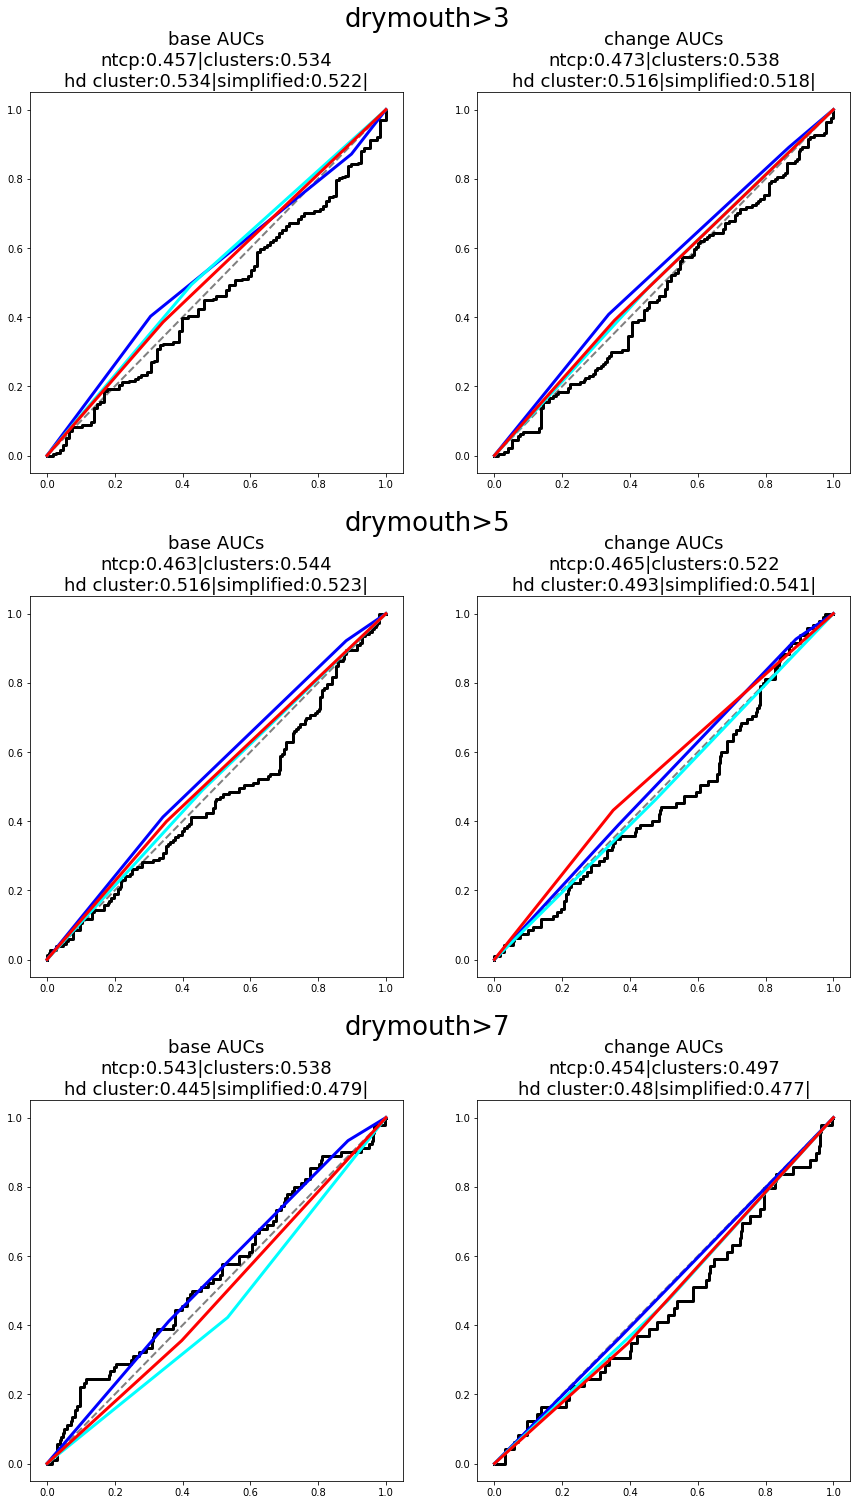

In [61]:
def plot_roc_curves(ct_list,thresholds=None,size=7,**kwargs):
    if thresholds is None:
        thresholds = [3,5,7]
    figsize=(2.1*size,size*len(thresholds))
    fig = plt.figure(constrained_layout=True,figsize=figsize)
    subfigures = fig.subfigures(len(thresholds),1)
    
    res = []
    for i, t in enumerate(thresholds):
        axes = subfigures[i].subplots(1,2)
        for row,use_change in enumerate([False,True]):
            axis= axes[row]
            for c in ct_list:
                y, y1, y0 = c.predict_cv(threshold=t,use_mimic=False,use_change=use_change,**kwargs)

#                 _, y2, y0_alt = c.predict_cv(threshold=t,use_mimic=True,use_change=use_change,**kwargs)
                
                #these are just static stratifications
                y3 = unsupervised_predictors(c, mimic=False,threshold=t)
                y4 = unsupervised_predictors(c, mimic=False,threshold=t,cluster=c.n_clusters-1)
                y5 = unsupervised_predictors(c, mimic=True,threshold=t)
                
                _, y6 = predict_ntcp_cv(c,threshold=t)
                axis.plot([0,1],[0,1],color='grey',linestyle='dashed',linewidth=2)
                colors = [
                    'black',
                    'blue',
                    'cyan',
                    'red',
                ]
                names = [
                    'ntcp',
                    'clusters',
                    'hd cluster',
                    'simplified',
                ]
                pstring = lambda p: str(np.round(p,2))
                title = ('change' if use_change else 'base') + ' AUCs\n'
                to_plot = [
                    y6,
                    y3,
                    y4,
                    y5,
                ]
                for iii, ycurr in enumerate(to_plot):
                    (fpr, tpr, _threh) = roc_curve(y,ycurr[:,1])
                    axis.plot(fpr,tpr,color=colors[iii],linewidth=3)
                    performance = get_stratification_metrics(y,ycurr)
                    pval = np.round(delong(y.astype(int), ycurr[:,1], y0[:,1])[0][0],3)
                    entry = {
                        'threshold': t,
                        'use_change': use_change,
                        'outcome': ','.join(c.symptoms),
                        'name': names[iii],
                    }
                    for k,v in performance.items():
                        entry[k] = v
                    entry['delong_pval'] = pval
                    res.append(entry)
                    title += names[iii] + ':' + str(np.round(performance['roc'],3))
                    if iii == 1:
                        title += '\n'
                    else:
                        title += '|'
                axis.set_title(title,fontdict={'fontsize': 18})
        suptitle = ''.join(ct_list[0].symptoms) + '>' + str(t) + '\n'
        subfigures[i].suptitle(suptitle,fontsize=26,y=1.05)
    plt.subplots_adjust(hspace=.4)
    return pd.DataFrame(res).groupby(['threshold','outcome','use_change','name']).first()

def plot_roc_sets(ct,df=None,organs=None,features=None, symptomlists = None, model=None,confounders=None,n_clusters=None,thresholds=None,**kwargs):
    if organs is None:
        organs = ct.cluster_organs[:]
    if df is None:
        df = ct.df.copy()
    if symptomlists is None:
        symptomlists = [
            ct.symptoms,
        ]
    if confounders is None:
        confounders = ct.default_confounders[:]
    if n_clusters is None:
        n_clusters = ct.n_clusters
    if features is None:
        features = ct.cluster_features[:]
    cts = []
    for symptoms in symptomlists:
        ctester = ClusterTester(df,
                       organs,
                       symptoms=symptoms, 
                       confounders=confounders,
                       n_clusters = n_clusters,
                        cluster_features=features,
                        outcome_dates = ct.outcome_dates[:],
                       **kwargs,
                      )
        ctester.get_mimic_clusters()
        cts.append(ctester)
    return plot_roc_curves(cts,model=model,thresholds=thresholds)

#get cross validation auc scores and then plot htem
plot_roc_sets(ct)

In [74]:
#below is additional analysis done for the paper looking at counfounders or details used in the appendix

(<Figure size 2160x720 with 12 Axes>,
 array([<matplotlib.figure.SubFigure object at 0x0000015F80B99550>,
       dtype=object))

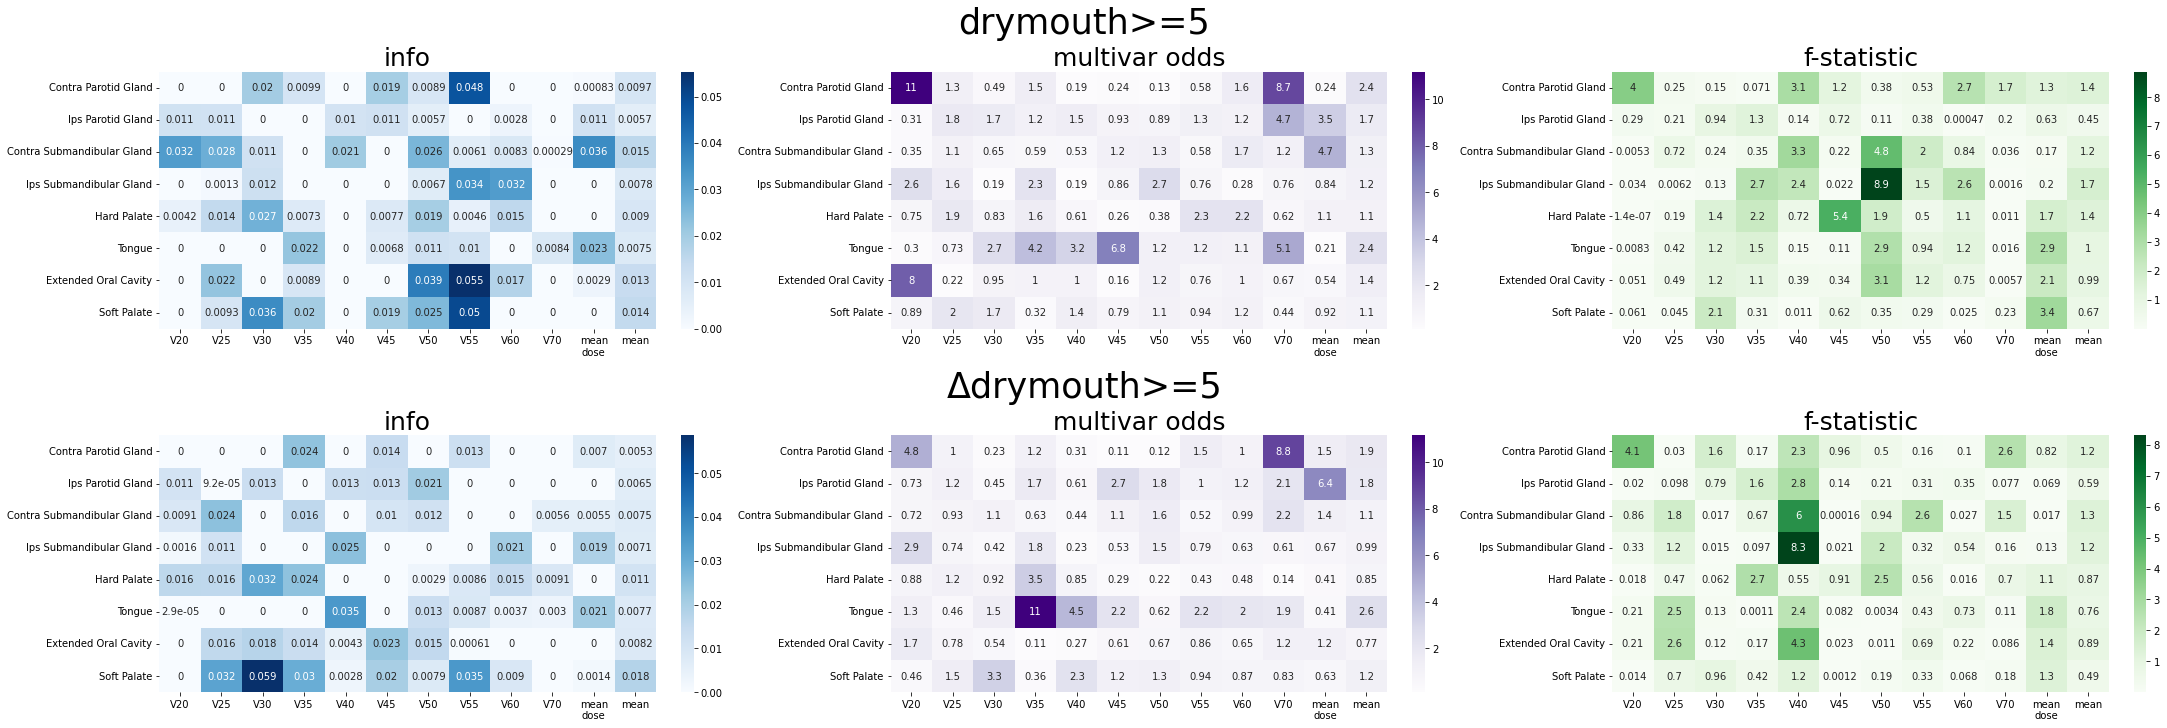

In [80]:
def get_dvhs(ctester,features=None,organs=None,**kwargs):
    if features is None:
        features= ctester.cluster_features[:]
    if organs is None:
        organs = ctester.cluster_organs[:]
        
    df = ctester.get_cluster_df(**kwargs)
    opositions = [Const.organ_list.index(i) for i in organs if i in Const.organ_list]
    filter_organs = lambda x: np.array([x[o] for o in opositions])
    vals = []
    for feature in features:
        farray = np.stack(df[feature].apply(filter_organs).values)
        vals.append(farray.T)
    vals = np.stack(vals,axis=-1) #organs x patients x features
    vals = np.swapaxes(vals,1,-1) #organs x features x patients
    return vals

def fix_oname(name):
    return name.replace('Lt_','Ips_').replace('Rt_','Contra_').replace('_',' ')

def multivar_odds(x,y,
                  regularize = True,
                  scale=True,
                  max_odds = 100,
                  alpha=None,
                   ):
    #this version uses sklearn because it doesn't work without it's good regularization
    if y.max() > 1:
        y = y/y.max()
        
    valid = [(x[:,i].std() > .001) for i in range(x.shape[1])]
    good_indices = [i for i,v in enumerate(valid) if v]
    good_x = np.stack([x[:,idx] for idx in good_indices],axis=1).astype(float)
    if regularize:
        good_x = (good_x - good_x.mean(axis=0))/(np.nanstd(good_x,axis=0))
    if scale:
        good_x = (good_x - good_x.min(axis=0))/(good_x.max(axis=0) - good_x.min(axis=0))
    good_x = np.nan_to_num(good_x,0)
    boolean = (len(np.unique(y)) <= 2)
    if boolean:
        if alpha is None:
            alpha = .1
        model = LogisticRegression(penalty='l2',C=1/alpha,max_iter=10000)
    else:
        if alpha is None:
            alpha = .0000001
        model = Ridge(alpha=alpha,positive=True)
    odds_vals = []
    
    m = model.fit(x,y)
    good_odds = m.coef_.ravel()
    if boolean:
        good_odds = np.exp(good_odds)
    odds = []
    pos = 0
    for is_valid in valid:
        if is_valid: 
            o = good_odds[pos]
            pos += 1
        else:
            o = 0
        if max_odds is not None:
            o = np.min([max_odds,o])
            if not boolean:
                o = np.max([-max_odds,o])
        odds.append(o)
    return np.array(odds)

def test_dvh_info(ctester,threshold=-1,metric='info',confounders=None,use_change=False,features=None,organs=None):
    if features is None:
        features= get_all_dvh(ctester)
    if confounders is None:
        confounders = ctester.default_confounders[:]
    confounder_df = ctester.df[confounders]
#     organs =  Const.organ_list[:] 
    if organs is None:
        organs = ctester.cluster_organs[:]
    darray = get_dvhs(ctester,features=features,organs=organs) #
    darray = np.swapaxes(darray,-1,0) #patients x features x organs
    darray = darray.reshape((darray.shape[0],-1)) #patients x features - organs
    darray = (darray - darray.mean(axis=1).reshape(-1,1))/(.0001 + darray.std(axis=1).reshape(-1,1))
    darray = (darray - darray.min(axis=1).reshape(-1,1))/(darray.max(axis=1).reshape(-1,1) - darray.min(axis=1).reshape(-1,1))
    darray = np.nan_to_num(darray)
    outcome = ctester.get_outcome(threshold=threshold,use_change=use_change)
    if confounders is not None and len(confounders) > 0:
        merged = np.concatenate([darray,confounder_df.values],axis=-1)
    else:
        merged = darray
    if 'odds' in metric and 'multi' in metric:
        info = multivar_odds(merged,outcome)
    else:
        if threshold > 0:
            if metric == 'info':
                info = mutual_info_classif(merged,outcome,n_neighbors=6,random_state=0)
            elif metric == 'pvalue':
                info = 1 - f_classif(merged,outcome)[1]
            else:
                info = f_classif(merged,outcome)[0]
        else:
            if metric=='info':
                info = mutual_info_regression(merged,outcome,n_neighbors=6,random_state=0)
            elif metric== 'pvalue':
                info = 1 - f_regression(merged,outcome)[1]
            else:
                info = f_regression(merged,outcome)[0]
    info = np.nan_to_num(info,1)
    res = {}
    pos = 0
    for f in features:
        values = []
        entry = {}
        for o in organs:
            curr_info = info[pos]
            values.append(curr_info)
            entry[fix_oname(o)] = curr_info
            pos += 1
        res[f] = entry
    df = pd.DataFrame(res)
    df['max'] = df.apply(lambda x: np.mean(x),axis=1)
    df = df.sort_values('max',ascending=False)
    return df.drop('max',axis=1)

def plot_dvh_correlations(ct,
                          metrics=None,
                          features = None,
                          thresholds=[-1],
                          organs = None,
                          **kwargs):
    if metrics is None:
        metrics = ['info','f-statistic']
    fig = plt.figure(constrained_layout=True,figsize=(10*len(metrics),len(thresholds)*5))
    axes = fig.subfigures(len(thresholds),1)
    if organs is None:
        organs = sorted(ct.cluster_organs[:])
    order = [fix_oname(o) for o in organs]
    color_dict = {
        'info': 'Blues',
        'f-statistic': "Greens",
        'multivar_odds': 'Purples'
    }
    for row, threshold in enumerate(thresholds):
        use_change = False
        thold = np.abs(threshold)
        if threshold < 0:
            use_change = True
        if thold == 1:
            thold = 0
                
        subfig = axes[row]
        title = ct.symptoms[0] 
        if use_change:
            title = 'Δ' + title
        if thold > 1:
            title += '>=' +str(thold)
        else:
            title += ' (linear)'
        subfig.suptitle(title,fontsize=35)
        subplots = subfig.subplots(1,len(metrics))
        for col, metric in enumerate(metrics):
            
            ax = subplots[col]
            temp = test_dvh_info(ct,
                                 metric=metric,
                                 use_change=use_change,
                                 threshold=thold,
                                 features=features,
                                 organs=organs,
                                 **kwargs)
            temp['mean'] = temp.values.mean(axis=1)
            d = temp.loc[order]
            d.columns = [c.replace('_','\n') for c in d.columns]
            sns.heatmap(d,ax=ax,cmap=color_dict.get(metric,'Reds'),annot=True)  
            
            title =  metric.replace('_',' ')
            ax.set_title(title,fontdict={'fontsize': 25})
    return fig,axes

#this looks at mutlivariate correlations between individual dvh values to organs of interest and out outcome using different metrics (mutual info, mulivariate test, f-statistic)
#to give an idea of what features are important
plot_dvh_correlations(ct,
                      metrics=['info','multivar_odds','f-statistic'],
                      features = ['V20','V25','V30','V35','V40','V45','V50','V55','V60','V70','mean_dose'],
                      thresholds = [5,-5],
                      confounders=['hpv'],
                      organs = ct.cluster_organs + ['Tongue','Extended_Oral_Cavity','Soft_Palate'],
                     )

E:\git_repos\DoseClusterDemo\Utils.py:28: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([subdf,df[ignore]],axis=1)


,threshold,covariate,effect,pvalue,outcome
25,-5,perf. score = 2,5.538462,0.049042,change >=5
12,5,perf. score = 2,2.604027,0.410621,absolute >=5
13,-5,T-stage 4,1.759001,0.155039,change >=5
2,5,N-stage 2,1.692471,0.017561,absolute >=5
15,-5,N-stage 2,1.669861,0.040563,change >=5
0,5,T-stage 4,1.500000,0.279323,absolute >=5
23,-5,age\n65,1.476923,0.141357,change >=5
16,-5,N-stage 3,1.405063,0.300344,change >=5
10,5,age\n65,1.294717,0.335438,absolute >=5
3,5,N-stage 3,1.210154,0.638805,absolute >=5


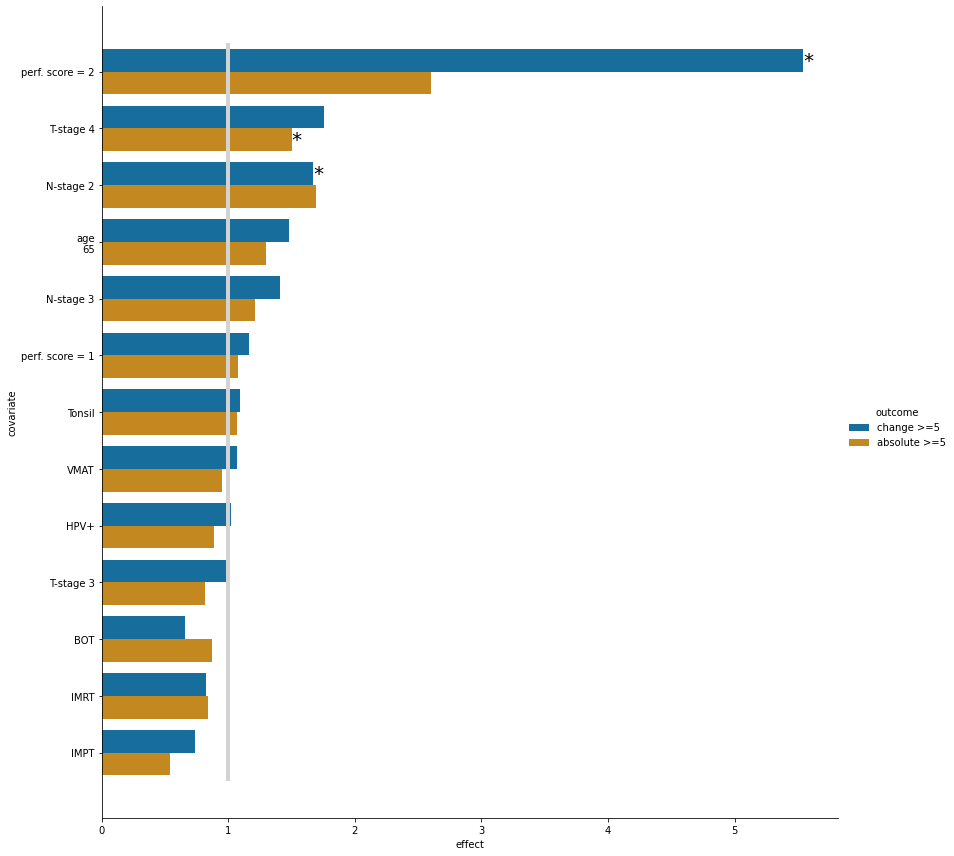

In [76]:
def get_confounder_correlations(ct,
                                use_cluster=True,
                                use_mimic=True,
                                cols = [
                                      't4','t3',
                                      'n2','n3',
                                      'HPV+',
                                      'IMRT','VMAT','IMPT',
                                      'BOT','Tonsil',
                                      'age_65',
                                      'performance_1','performance_2',
                                  ],
                                use_limits = False):
    df = ct.df.copy()
    name_map = {
        't4': 'T-stage 4',
        't3': 'T-stage 3',
        'n2': 'N-stage 2',
        'n3': 'N-stage 3',
        'hpv_pos': 'HPV+',
        't_severe': 'T-stage > 2',
        'n_severe': 'N-stage > 1',
        'age_65': 'age > 65',
        'performance_1_1': 'perf. score = 1',
        'performance_2_1': 'perf. score = 2',
        'performance_high': 'perf. score > 0',
    }
    df['HPV+'] = df.hpv.apply(lambda x: x==1)
    to_keep = cols[:]
    if use_cluster:
        cluster_df = ct.get_cluster_df()
        
        cluster_df = Utils.onehotify(df[['dose_clusters']])
        for col in cluster_df.columns:
            to_keep.append(col)
            df[col] = cluster_df[col]
            
    if use_mimic:
        mimic_df = ct.get_cluster_df(use_mimic=True)
        df['simple_cluster'] = mimic_df['dose_clusters'].astype(bool)
        to_keep.append('simple_cluster')
    if use_limits:
        to_keep = to_keep + [c for c in df.columns if '_limit' in c and 'Brainstem' not in c and c not in cols]
    df = Utils.onehotify(df[to_keep],drop_first=True)
    thresholds = [5]
    results = []
    for use_change in [False,True]:
        for threshold in thresholds:
            y = ct.get_outcome(threshold = threshold,use_change=use_change)
            for col in df.columns:
                ypred = df[col].fillna(0).values
                if threshold > 0:
                    [effect,pval] = boolean_fisher_exact(y,ypred)
                else:
                    [effect,pval] = vector_chi2(y,ypred)
                if use_change:
                    t = -threshold
                else:
                    t = threshold
                cname = name_map.get(col,col)
                cname = cname.replace('_1','').replace('.0','').replace('_True','').replace('_','\n')
                cname = name_map.get(cname,cname)
                entry = {
#                     'outcome_change':use_change,
                    'threshold':t,
                    'covariate': cname,
                    'effect': effect,
                    'pvalue': pval,
                }
                results.append(entry)
    return pd.DataFrame(results)#.groupby(['outcome_change','threshold','covariate']).first()

def plot_confounder_correlations(ct,**kwargs):
    ccors = get_confounder_correlations(ct,**kwargs)
    ccors['outcome'] = ccors.threshold.apply(lambda x: 'absolute >=' + str(x) if x >= 0 else 'change >=' + str(np.abs(x)) )
    ccors = ccors.sort_values('effect',ascending=False)
    chart = sns.catplot(
        data=ccors,
        height=12,
        aspect=1,
        x='effect',
        y='covariate',
        hue='outcome',
        kind='bar',
        orient='h',
        palette='colorblind',
    )
    ax = chart.facet_axis(0,0)
    for c in ax.containers:
        threshold = c.get_label()
        pvals = ccors[ccors.outcome==threshold].pvalue.values
        labels = [('' if p > .05 else '*') for p in pvals]
        ax.bar_label(c,labels=labels,label_type='edge',fontsize=20)
        ax.vlines(1,-.5,len(ccors.covariate.unique())-.5,color='lightgrey',linewidth=4)
    return ccors

#plot correaltions between covariates and our outcome using fischer exact test (if boolean) or chi2 otherwise
plot_confounder_correlations(ct,use_limits=False,use_mimic=False,use_cluster=False)

E:\git_repos\DoseClusterDemo\Utils.py:28: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([subdf,df[ignore]],axis=1)


,threshold,covariate,effect,pvalue,outcome
13,-5,Spinal\nCord\nlimit,2.806818,0.065445,change >=5
0,5,Spinal\nCord\nlimit,1.747126,0.411084,absolute >=5
23,-5,Larynx\nlimit,1.659574,0.077016,change >=5
4,5,IPC\nlimit2,1.423810,0.410271,absolute >=5
10,5,Larynx\nlimit,1.322245,0.292543,absolute >=5
17,-5,IPC\nlimit2,1.281947,0.641423,change >=5
15,-5,Parotid\nGland\nlimit2,1.142397,0.679240,change >=5
18,-5,MPC\nlimit,1.113173,0.711959,change >=5
3,5,IPC\nlimit,1.048121,0.891606,absolute >=5
5,5,MPC\nlimit,1.009040,1.000000,absolute >=5


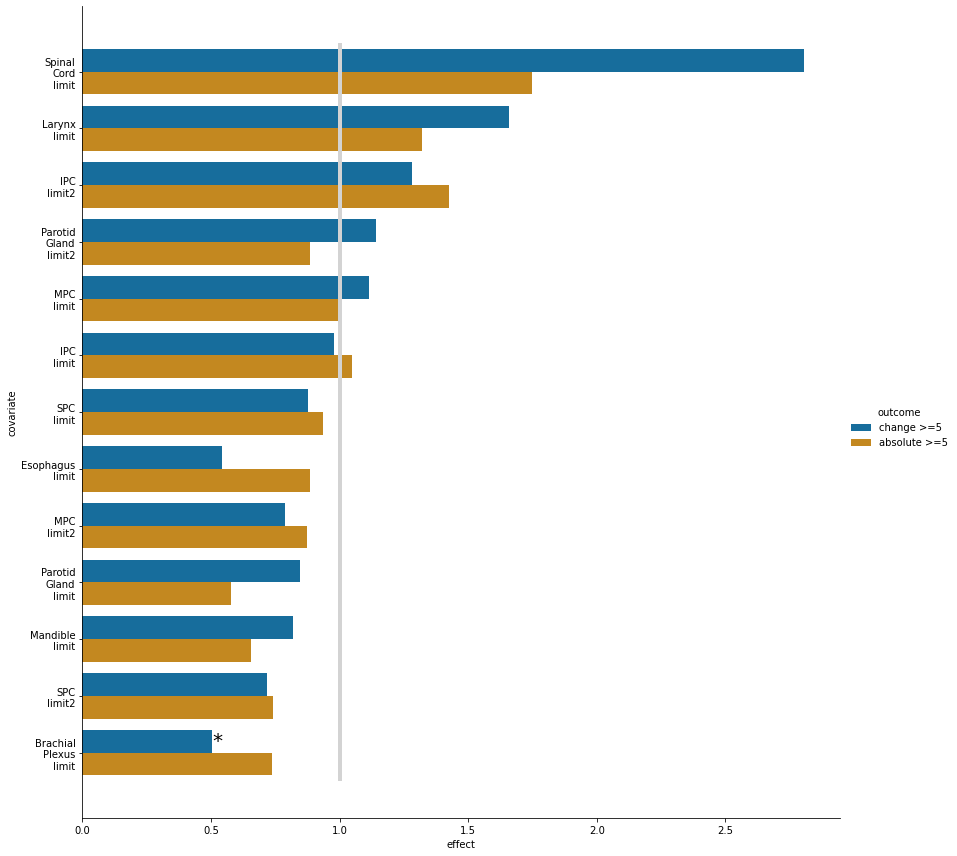

In [81]:
#correlations between dose limits and outcomes
plot_confounder_correlations(ct,use_limits=True,use_mimic=False,use_cluster=False,cols=[])

In [82]:
def get_limit_performance(ct,
                          other_cols = [
                              't4','t3','t_severe',
                              'n3','n_severe',
                              'IMRT','VMAT',
                              'age_65','old',
                              'performance_1','performance_2','performance_high'
                          ]
                         ):
    df = ct.df.copy()
    limits = [c for c in df.columns if '_limit' in c]
    y = ct.get_outcome()
    results = []
    for limit in limits + other_cols:
        subdf = df[~df[limit].isnull()]
        ypred = np.zeros((len(y),2))
        ypred[:,1] = subdf[limit].values
        ypred[:,0] = ~subdf[limit].values
        res = get_stratification_metrics(y,ypred)
        res['name'] = limit
        results.append(res)
    return pd.DataFrame(results).sort_values('mcc',ascending=False)

#get the predictive performance of different confounders
#and existing dose limits on the outcome (drymouth)
get_limit_performance(ct)

E:\git_repos\DoseClusterDemo\Stats.py:448: RuntimeWarning: invalid value encountered in double_scalars
  fbeta = lambda b: (1+b**2)*(precision*recall)/((b**2)*precision + recall)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
E:\git_repos\DoseClusterDemo\Stats.py:452: RuntimeWarning: divide by zero encountered in double_scalars
  dor = (recall*precision)/((1-recall)*(1-precision))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
E:\git_repos\DoseClusterDemo\Stats.py:452: RuntimeWarning: divide by zero encountered in double_scalars
  dor = (recall*precision)/((1-recall)*(1-precision))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:873: RuntimeWarning: invalid value encountere

,roc,mcc,dor,accuracy,precision,recall,f1,f_half,f2,name
11,0.523259,0.056752,0.299376,0.558739,0.493151,0.235294,0.318584,0.404494,0.262774,Larynx_limit
1,0.510838,0.054809,0.073563,0.567335,0.571429,0.052288,0.095808,0.191388,0.063898,Spinal_Cord_limit
5,0.511871,0.045684,0.100595,0.564470,0.520000,0.084967,0.146067,0.256917,0.102041,IPC_limit2
4,0.503651,0.009200,0.197759,0.541547,0.447761,0.196078,0.272727,0.356295,0.220913,IPC_limit
6,0.501067,0.002174,1.248023,0.487106,0.439252,0.614379,0.512262,0.465808,0.569007,MPC_limit
25,0.478541,0.000000,inf,0.438395,0.438395,1.000000,0.609562,0.493867,0.796046,performance_high
15,0.488112,0.000000,inf,0.438395,0.438395,1.000000,0.609562,0.493867,0.796046,t3
14,0.518007,0.000000,inf,0.438395,0.438395,1.000000,0.609562,0.493867,0.796046,t4
18,0.530162,0.000000,inf,0.438395,0.438395,1.000000,0.609562,0.493867,0.796046,n_severe
16,0.535214,0.000000,inf,0.438395,0.438395,1.000000,0.609562,0.493867,0.796046,t_severe
